<a href="https://colab.research.google.com/github/wooihaw/flowers_classification/blob/main/eight_flowers_cnn_transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Classification of eight types of flowers with transfer learning
##In this example, we are going to train a CNN model with transfer learning for the classfication of eight types of flowers

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content')

Mounted at /content/drive


In [2]:
# Extract dataset from Google Drive
!cd /content/datasets
!unzip /content/drive/MyDrive/eight_flowers.zip > /dev/null

In [3]:
# Load modules
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Setup foldres for training, validation and testing images
train_dir = 'eight_flowers/train/'
test_dir = 'eight_flowers/test/'
val_dir = 'eight_flowers/valid/'

# Stream images from folders
train_datagen = ImageDataGenerator(rescale=1/255.)

test_datagen = ImageDataGenerator(rescale=1/255.)

val_datagen = ImageDataGenerator(rescale=1/255.)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    batch_size=32,
                    target_size=(150,150),
                    class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
                    test_dir,
                    batch_size=32,
                    target_size=(150,150),
                    class_mode='categorical')

val_generator = val_datagen.flow_from_directory(
                    val_dir,
                    batch_size=32,
                    target_size=(150,150),
                    class_mode='categorical')

Found 6221 images belonging to 8 classes.
Found 520 images belonging to 8 classes.
Found 582 images belonging to 8 classes.


In [5]:
# Import the inception mode, do not include the fully-connected layer at the top as the last layer of the network
base_model = InceptionV3(input_shape=(150, 150, 3), include_top=False, weights='imagenet')

# Make all the layers in the pre-trained model non-trainable
for layer in base_model.layers:
    layer.trainable = False

# Print the model summary
base_model.summary()

last_layer = base_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

# Applies average pooling on the spatial dimensions until each spatial dimension is one
x = GlobalAveragePooling2D()(last_output)
# Add a fully connected layer with 1024 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = Dense(8, activation='softmax')(x)

model = Model(base_model.input, x)

model.compile(optimizer ='rmsprop',
              loss = 'categorical_crossentropy',
              metrics = ['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=195,
                    epochs=3,
                    validation_data=val_generator,
                    validation_steps=19,
                    verbose=1)

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d_94 (Conv2D)          (None, 74, 74, 32)           864       ['input_2[0][0]']             
                                                                                                  
 batch_normalization_94 (Ba  (None, 74, 74, 32)           96        ['conv2d_94[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_94 (Activation)  (None, 74, 74, 32)           0         ['batch_normalizati

In [6]:
scores = model.evaluate(test_generator)
print(f"{model.metrics_names[0]}: {scores[0]:.2f}")
print(f"{model.metrics_names[1]}: {scores[1]:.2%}")

17/17 [==============================] - 2s 131ms/step - loss: 0.4046 - acc: 0.8615
loss: 0.40
acc: 86.15%


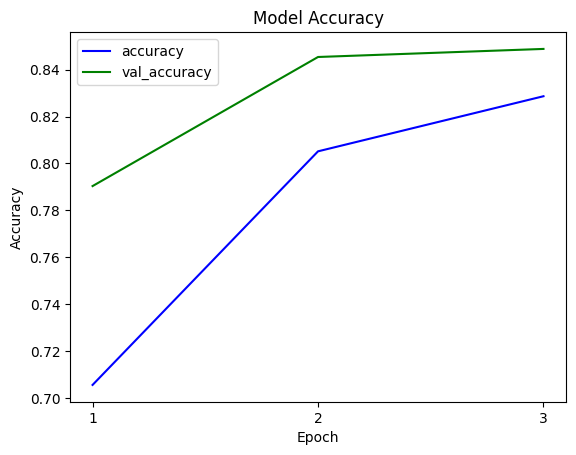

In [7]:
# Plot model accuracy and lose
acc = history.history['acc']
loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.plot(np.arange(1, len(acc) + 1), acc, 'b', label='accuracy')
plt.plot(np.arange(1, len(val_acc) + 1), val_acc, 'g', label='val_accuracy')
plt.xlabel('Epoch')
plt.xticks(np.arange(1, len(acc) + 1))
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc=0)
plt.show()

plt.plot(np.arange(1, len(loss) + 1), acc, 'b', label='loss')
plt.plot(np.arange(1, len(val_loss) + 1), val_acc, 'g', label='val_loss')
plt.xlabel('Epoch')
plt.xticks(np.arange(1, len(acc) + 1))
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc=0)
plt.show()

In [10]:
# serialize model to JSON
model_json = model.to_json()
with open("model2.json", "w") as json_file:
  json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model2.h5")
print("Saved model to disk")

from json import dump
with open('class_indices2.json', 'w') as f:
  dump(train_generator.class_indices, f)

Saved model to disk


In [11]:
# Test the trained model on a new image
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from json import load
import numpy as np

# load json and create model
json_file = open('model2.json', 'r')
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
# load weights into new model
model.load_weights("model2.h5")

# load class indices
with open('class_indices2.json', 'r') as f:
    class_indices = load(f)
print("Model loaded from disk")
map2class = {class_indices[k]:k for k in class_indices}

Model loaded from disk


1/1 [==============================] - 2s 2s/step
[[1.2991713e-04 4.1802600e-02 8.2255745e-01 3.3726907e-04 2.0471701e-02
  1.8913871e-02 5.9871327e-02 3.5915826e-02]]
daffodil  :  0.000
daisy     :  0.042
dandelion :  0.823
iris      :  0.000
rose      :  0.020
sunflower :  0.019
tulip     :  0.060
water_lily:  0.036


Text(0.5, 0, 'Predicted as dandelion')

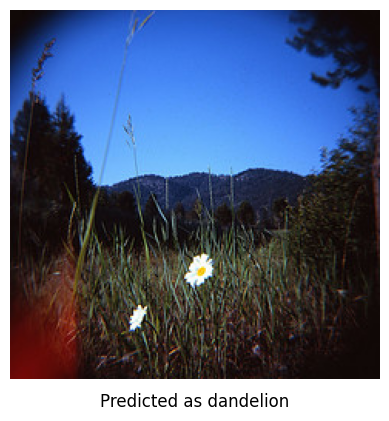

In [12]:
# Display the test image and show the predicted class
file = 'eight_flowers/test/sunflower/sunflower_test_0001.jpg'
img = load_img(file, target_size=(150, 150))
x = img_to_array(img)/255.
x = np.expand_dims(x, axis=0)
classes = model.predict(x)
print(classes)
for i, k in enumerate(class_indices):
  print(f'{k:10}: {classes[0, i]: .3f}')

plt.axis(False)
plt.imshow(load_img(file))
plt.title(f'Predicted as {map2class[classes.argmax()]}', y=0, pad=-10, verticalalignment="top")